## S2 To R1 Attractor, S2 Damping - Geometric Consistency Test (PBDS)

In [1]:
using PBDS, StaticArrays, LinearAlgebra, BenchmarkTools

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-9486861102313925960\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-10758943745678599493\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-9486861102313925960\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

## Setup

### Point Distance Attractor

In [2]:
PBDS.task_map_emb(::EmbRep, ::EmbRep, xme, task_map::DistanceFromPoint{S2,R1}) where n =
    SA[norm(xme - task_map.position_center)]
PBDS.domain_coord_rep(::DistanceFromPoint{S2,R1,S}) where S = EmbRep()

PBDS.metric_chart(xn, task::Attractor{<:DistanceFromPoint{S2,R1,S}}, CN::Chart{1,R1}) where S = 
    default_metric(xn, task, CN)
PBDS.potential_chart(xn, task::Attractor{<:DistanceFromPoint{S2,R1,S}}, CN::Chart{1,R1}) where S = xn[1]^2
PBDS.dissipative_forces_chart(xn, vn, task::Attractor{<:DistanceFromPoint{S2,R1,S}}, CN::Chart{1,R1}) where S =  0*vn
PBDS.weight_metric_chart(xn, vn, task::Attractor{<:DistanceFromPoint{S2,R1,S}}, CN::Chart{1,R1}) where S = 
    default_weight_metric(xn, vn, task, CN)

### Sphere Damping

In [3]:
PBDS.default_coord_rep(::Damping{<:Identity{S2,S2,S}}) where S = EmbRep()
PBDS.metric_emb(xne, task::Damping{<:Identity{S2,S2,S}}) where S =
    default_metric(xne, task)
PBDS.potential_emb(xne, task::Damping{<:Identity{S2,S2,S}}) where S = 0.
PBDS.dissipative_forces_emb(xne, vne, task::Damping{<:Identity{S2,S2,S}}) where S = -4*vne
PBDS.weight_metric_emb(xne, vne, task::Damping{<:Identity{S2,S2,S}}) where S =
    default_weight_metric(xne, vne, task)
PBDS.home_task_chart(task::Damping{<:Identity{S2,S2,S}}) where S = Chart{SterProjSouth,S2}()

In [4]:
M = S2
tasks, CNs = TaskList(), ChartList()

N = R1
CN = Chart{1,N}()
center = SA[1., -1., -1.]
center = center ./ norm(center)
push!(tasks, Attractor(DistanceFromPoint{M,N}(center)))
push!(CNs, CN)

N = S2
CN = Chart{SterProjNorth,S2}()
push!(tasks, Damping(Identity{M,N,Float64}()))
push!(CNs, CN)

2-element Array{Chart,1}:
 Chart{1,ℝ{1}}()
 Chart{SterProjNorth,𝕊{2}}()

## Point Acceleration

In [5]:
# Initial state
xme = SA[-1., 1., 1.]
xme = xme ./ norm(xme)
vme = SA[2., 1., 1.]
robot_coord_rep = EmbRep()

CM = Chart{SterProjNorth,S2}()
PBDS.choose_chart_emb(::EmbRep, pe, ::Chart{<:SterProj,S2}) = Chart{SterProjNorth,S2}()
σxddot, = multiple_task_acceleration(xme, vme, tasks, CM, CNs, robot_coord_rep)

([-4.535898384862247, -7.4641016151377615, -7.464101615137746], Chart[])

In [6]:
CM = Chart{SterProjSouth,S2}()
PBDS.choose_chart_emb(::EmbRep, pe, ::Chart{<:SterProj,S2}) = Chart{SterProjSouth,S2}()
σxddot, = multiple_task_acceleration(xme, vme, tasks, CM, CNs, robot_coord_rep)

([-4.535898384862246, -7.464101615137755, -7.464101615137755], Chart[])

## Single Trajectory

In [7]:
using Plots, Makie, Observables, ProgressMeter

In [8]:
Time = 15
dt = 0.01

PBDS.choose_chart_emb(::EmbRep, pe, ::Chart{<:SterProj,S2}) = Chart{SterProjNorth,S2}()
traj_north = propagate_tasks(xme, vme, tasks, CM, CNs, Time, dt, robot_coord_rep, log_tasks = true)

PBDS.choose_chart_emb(::EmbRep, pe, ::Chart{<:SterProj,S2}) = Chart{SterProjSouth,S2}()
traj_south = propagate_tasks(xme, vme, tasks, CM, CNs, Time, dt, robot_coord_rep, log_tasks = true)

PBDS.choose_chart_emb(::EmbRep, pe, ::Chart{<:SterProj,S2}) =
    (pe[3] < 0)[1] ? Chart{SterProjSouth,S2}() : Chart{SterProjNorth,S2}()
traj_switching = propagate_tasks(xme, vme, tasks, CM, CNs, Time, dt, robot_coord_rep, log_tasks = true)
traj_switching.xm[end]

3-element SArray{Tuple{3},Float64,1,3} with indices SOneTo(3):
  0.5775141440325302
 -0.5772683143297737
 -0.5772683143159995

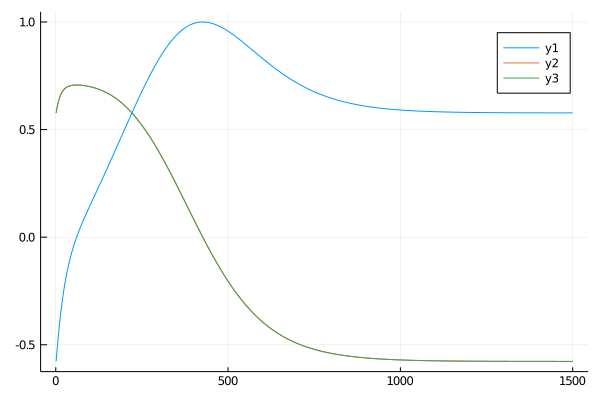

In [9]:
Nplot = length(traj_switching.xm)
Plots.plot(getindex.(traj_switching.xm,1)[1:Nplot])
Plots.plot!(getindex.(traj_switching.xm,2)[1:Nplot])
Plots.plot!(getindex.(traj_switching.xm,3)[1:Nplot])

In [10]:
ax_size, plot_size = 1, 800
limits = FRect3D((-ax_size, -ax_size, -ax_size), (2*ax_size, 2*ax_size, 2*ax_size))
scene = Scene(resolution = (plot_size, plot_size))
mesh!(Sphere(Point3(zeros(3)), 1.), color = RGBA(1.,1.,1.,0.4), transparency = true)
Makie.scatter!(scene, [xme[1]], [xme[2]], [xme[3]], markersize = ax_size/20, color = :blue, limits = limits)
δ = 0.99
Makie.scatter!(scene, [center[1]*δ], [center[2]*δ], [center[3]*δ], markersize = ax_size/20, color = :green, limits = limits)

linewidth = 1.5
Makie.lines!(scene, getindex.(traj_switching.xm,1), getindex.(traj_switching.xm,2), getindex.(traj_switching.xm,3), color = :purple, linewidth = linewidth)
Makie.lines!(scene, getindex.(traj_south.xm,1), getindex.(traj_south.xm,2), getindex.(traj_south.xm,3), color = :red, linewidth = linewidth)
Makie.lines!(scene, getindex.(traj_north.xm,1), getindex.(traj_north.xm,2), getindex.(traj_north.xm,3), color = :blue, linewidth = linewidth)

axis = scene[Axis]
axis.showaxis = false
rotate_cam!(scene, 0.4, 0., 0.)
display(scene)

GLMakie.Screen(...)

## Animation

In [11]:
iobs = Observable(1)
AbstractPlotting.__init__()
Makie.AbstractPlotting.inline!(false)
ax_size, plot_size = 1, 800
limits = FRect3D((-ax_size, -ax_size, -ax_size), (2*ax_size, 2*ax_size, 2*ax_size))
scene = Scene(resolution = (plot_size, plot_size))
mesh!(Sphere(Point3f0(zeros(3)), 1.), color = RGBA(1.,1.,1.,0.4), transparency = true)
δ = 1
Makie.scatter!(scene, [center[1]*δ], [center[2]*δ], [center[3]*δ], markersize = ax_size/20, color = :green, limits = limits)

accel_rate = 2
# Makie.scatter!(scene, lift(i -> [traj_switching.xm[(i-1)*accel_rate+1][1]], iobs), lift(i -> [traj_switching.xm[(i-1)*accel_rate+1][2]], iobs), lift(i -> [traj_switching.xm[(i-1)*accel_rate+1][3]], iobs), markersize = ax_size/16, color = :purple, limits = limits)
# Makie.scatter!(scene, lift(i -> [traj_south.xm[(i-1)*accel_rate+1][1]], iobs), lift(i -> [traj_south.xm[(i-1)*accel_rate+1][2]], iobs), lift(i -> [traj_south.xm[(i-1)*accel_rate+1][3]], iobs), markersize = ax_size/18, color = :red, limits = limits)
Makie.scatter!(scene, lift(i -> [traj_north.xm[(i-1)*accel_rate+1][1]], iobs), lift(i -> [traj_north.xm[(i-1)*accel_rate+1][2]], iobs), lift(i -> [traj_north.xm[(i-1)*accel_rate+1][3]], iobs), markersize = ax_size/20, color = :blue, limits = limits)

linewidth = 2.5
Makie.lines!(scene, getindex.(traj_switching.xm,1), getindex.(traj_switching.xm,2), getindex.(traj_switching.xm,3), color = :purple, linewidth = linewidth)
Makie.lines!(scene, getindex.(traj_south.xm,1), getindex.(traj_south.xm,2), getindex.(traj_south.xm,3), color = :red, linewidth = linewidth)
Makie.lines!(scene, getindex.(traj_north.xm,1), getindex.(traj_north.xm,2), getindex.(traj_north.xm,3), color = :blue, linewidth = linewidth)

Makie.xlabel!(scene, "x")
Makie.ylabel!(scene, "y")
axis = scene[Axis]
axis.showaxis = false
rotate_cam!(scene, 0.4, 0., 0.)
display(scene)

GLMakie.Screen(...)

In [12]:
function record_scene(scene, filename, iobs, N, framerate=60)
    p = Progress(N)
    record(scene, filename, 1:N) do i
        iobs[] = i
        rotate_cam!(scene, 0.01, 0., 0.)
        next!(p)
    end
    display("text/html", html_video(filename))
end

filename = "S2_To_R1Attractor_S2Damping_ConsistencyTest.mp4"
record_scene(scene, filename, iobs, Int(floor(length(traj_north.xm)/accel_rate)))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAqCbxtZGF0AAACoQYF//+d3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjQgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD01MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIwLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAFMkZYiEAC///vdOvwKbRZdqA5JXCvbKpCZZuVJrAfKmAACBoUAAAAMAAAWBsoyrtIqFAzgAAAMAEgAC+gNOBUoRnv3wO0OitbaNb1wSR+tPeT7JJmGZx6OA6eSjz5i9v2EhbT1C/r5Wm0V/ZVsjcrYH13D9GNtCUJB9L7mHGQlaC4sNa9c3qSQ7wgusVzwBFE7F9ik8WocqmXIcZXkzayZKJF0wrJhFIihjzXIAj6WrSXAO70CGfUiKu4jRwTBQQgzv8t+GOYTMh6KZCftOcPjACL5zlJzWzE6a2dDxe0hePCVe0YUlRIC4uwpYXPATXzws++QnkS8GxwW4bwebIO4Ed2dW/X28+FFrkFa2L6YGcDiPyY3/J9+kV1p+LIwYvvvBx+/Q9S25ALG0GHE/81CsVyH97e85N+f2qHWCFze1M7hDPr27F2P9Q1XGwhjIpOqKCC1vQ289aGextlGMZrLA2zPmsY6cHmN5D8WywXJ9dzMvnkVjB3nIa5ZfbHIkOXMEvW8CHCQWFuDFtRpLtgg38h/QUgDr4tx8lkF/Zn35kYK/FJfVJJ5Gjvnv6KV3MC5SZDzHjg56dpaFBeUXTuTn0sSXae3zsHmd6+vyI0UnZNeYO/2iz6SqJD8De6k3POPBJ2EhSwsf+UHFvpYJaYLYpKpBfObILz6gDT470Y0Qb6D8yDUULOak/ZIe/E5upkCpVbaxmgSyKXMTKOd908vUyrP9OyxKj+kM3UdekHTp1+PDFajonSXvqUpFAqQFsIGta4NFkWYBmdBTC7Z4WG3ZUPcLyX7jYoOx7yvmySp0suysFQjo8ZmnvsKGxOPwe0G7PpnMNGFymJihdjL61syiTacFjGjtdf+XEbgQ3ltqKIdeALuZOFo8qmCJRisznLhy9SH8MmyHdt3nLswxXi1ZbFGrfSXYhROaRh72of0nfSzjO5y+5RqsJJfWOPYwVFvcr+sliswkl4mNdVZhh8R/K+TGgR1qPs2k6IzzmG7fydV4Hs6hcUmjYrBKbMqe4f8vg5HP17GIYckZyWPC6dN5DzG9lHXthjUKW/NtlKJXUAi73Kzbtn/GD79g4CrszsEhZGRG7lIeFuf7Ob7SCTAtlDfiLRbPdm2AedCGvLX8SbbVGTWUlG/9tWOPWcyL9ByNC7LALG2XNede6ian7Y3ziItf1L1EhIaa8pq1vJ7OBbxXnnIfUHgx3YhJKnbgmw4Req+9CUjI7NxLpITbF/sn0eCaolqe3+LO8j2CS7bOE+RiArVlvV7Dqj0rjc4/Umw70vllRc6nLvZe4U/kpVZBRMQbHAciM6OqZ7RaMWtYMxweoM1ZU85JmhWfD+R5ph3tZy6hWaS4L646nCCLyD/U0E7HyZCzLva+o5uwvQrPz9ejhB9cV63X0+6qC7KOX5Jg2IQ0ePykbzBaa0DbsBQ+3Xb8B89IvRH+Wmx18uQbyBcofh6xQeR+eR8Lc0WN/8wWQ3siPkGHYAi9lhqClYB/wiScohPIDE4Uo9OH0r0pTVgLxZl3J0BJt5TdK/qXoe3x07FXpUs9gT4kUNf1FH+3gz/5pALjmblkErazvkeywEJtuwm2G8jroNuJ6r7p5hdIC1ajjeTOuxdit4/ZlnPEwvL3BeW5Nmu5w0WKGMhOrz/Qr7i24jYqCLU15QrMIeffMZIWrAuI8xtv3QZv9H5m4M7oeBkyffcUV0MQPn5527TMTLRppWgx0S6ClresIuVbuqoRKNntI2NIGd5rcxa2emM9aSxEHx6qJspV2iDFHe5XBDOKX6zOPPlglDj5uSdydhHQfA/9A0nYWM/7OTr2/g1WlZA5H9mef1lCcackAI9Imtv0f6g8ZyN3/RPu4D/hNYTdMsmoMfBqOVe4oLvic6wOu7RJNeITuy4mmYHRQ/5ujdtyFaOVArd9lFsJaLk+M2z5PhU3+nmHXZPWTktl90EmoZiOLufAkSugGMnXzUCoRmK+LFilNoCYHqtTLkah6W4/DTtx6dwZIbp+GeCy5iqQ0BTzdda9g2VGdpbVu0iO/wawNsA9f7QcPX9v+fqME88QKfhk26bh9dkM5du/D5igu4mZao3D2gSbZGw7ujKNDti1I+54l4zE1HLqu8f52avZUzc4gf8hUjgWariS1rGzu0EvyG5geBuSQi+RW//mq1QFbJFOIZDDYqEtf+CL4BmxndMMvV1Jw62cJGsHaXyIXrjQnoa4U2V8qYg9nOfDOV5qu2bvYQS/EFqvBP9P0GpwaTJVNm405yHHFBQAfQtqUG9MhtVU+BhLz4KNBE8tCuPj1+T8zJtR177gAPtdIXTtFpQHNayU27cOfp7TPo6k2wcrGzJUM9GcOSb8U74GIaxaOuZgKBTDzW7lr8bP4LHKUQKp5GcOxONzRrDygLy092j/JaDZqGWb2G1mzitoqYZjXBPy8cL4HSnu265FPyl6G5hJmxXYS6Y02AlUrUHB5UiTBkvzWM5qbCWixTOBT8BUIMimRiCnKsW1DqieDhS32rg9WdwsiZLFJEK/ZaGFpV3ijCXF4PpsYDPyecZwIR7CqxP0fnOuqVTxxZaxdin8fDDkg1XCiu02HFiULuTgfGA+2Nj/4yiwPqNfd8l6ZIRktf+qsCD/jCe0cYqEuzzRsJ8gJUpt0ctrwMwOIrqUKO1KWfhf7mupLvG5qoWCZau7tnqVtlomxvQBYVdfPL33bL9GTCWgSFdk8L6lCIwzKV3kugtOsCoe1YhAumVaC3J3BU90y3syL4sQCquIzHrqwpI6g42nGZqOg+WA0nzKxkA6no+wcgxamRQZDrZeivhcvmE0dPKFbEgwb46QEc+45E/wGNFjko2rbsPfjSCJWXzOoDfKhyc5Moz3+KkYS1eiJ4jsGKgpQOi7Ajxc+ex6iI5A7Tji5w1TInIOMjqYcoEN82CsMOIwY7tQxpSn5xnOtX8ElNM2Qoq2x5myQF9vpjlLMjEI4vWKg0cAk8Oan4RY7UegdWWBOOV